In [1]:
%matplotlib inline

# Task 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import  linear_model
import seaborn as sns
np.set_printoptions(precision=3)
plt.rcParams.update({'font.size': 22})


In [2]:
path_X = "../Project1_data/X.csv"
X = pd.read_csv(path_X)
path_Y = "../Project1_data/Y.csv"
Y = pd.read_csv(path_Y)

merged = X.copy()
merged["DispFrames"] = Y["DispFrames"]


In [3]:
def NMAE(gt,pred,test_size):
    psum = 0
    gt = np.array(gt)
    for i in range(0,test_size):
        psum+= abs(gt[i] - pred[i])
    tmp = psum / test_size
    return tmp / np.mean(gt)

def Cycle():

    merged = X.copy()
    del merged["TimeStamp"]
    merged["DispFrames"] = Y["DispFrames"]
    T = merged.sample(1000,replace=False)
    merged = merged.drop(T.index)
    S = []
    NMAEs = []
    ticks = [50,100,200,400,800,1600]
    for i in range(0,len(ticks)):
        S.append(merged.sample(ticks[i],replace=False))

        test_labels = T.iloc[:,-1:]
        test_features = T.iloc[:,:-1]
        train_labels = S[i].iloc[:,-1:]
        train_features = S[i].iloc[:,:-1]
        regr = linear_model.LinearRegression()
        regr.fit(train_features,train_labels)
        pred = regr.predict(test_features)
        
        NMAEs.append(NMAE(test_labels,pred,len(test_labels)))
    return NMAEs
ticks = [50,100,200,400,800,1600]
df = pd.DataFrame(columns=ticks)
for i in range(0,50):
    df.loc[i] = [e[0] for e in Cycle()]
print(df)



        50        100       200       400       800       1600
0   0.104875  0.091645  0.091393  0.090368  0.092610  0.090558
1   0.136306  0.110323  0.095962  0.096069  0.096868  0.095639
2   0.108871  0.109672  0.085550  0.087265  0.085205  0.083380
3   0.125062  0.105881  0.097369  0.092523  0.091814  0.091864
4   0.123419  0.096490  0.088549  0.090445  0.087823  0.087108
5   0.106189  0.097886  0.091612  0.088750  0.087462  0.086659
6   0.116570  0.087738  0.089566  0.084919  0.085686  0.085274
7   0.101664  0.090490  0.092404  0.088111  0.085777  0.085428
8   0.095892  0.095933  0.083784  0.084061  0.082563  0.082686
9   0.096833  0.103340  0.090778  0.089411  0.088591  0.087540
10  0.142125  0.115309  0.093241  0.093081  0.091806  0.090501
11  0.137382  0.155716  0.095084  0.095451  0.091369  0.089631
12  0.102694  0.139146  0.088843  0.087907  0.090173  0.087980
13  0.109403  0.098153  0.095776  0.092261  0.093802  0.093544
14  0.094772  0.085226  0.084510  0.086633  0.082749  0

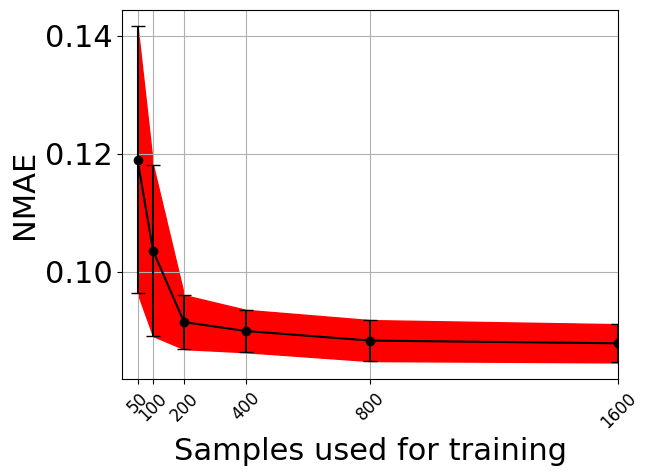

In [4]:
mean_errors = df.mean()
std_dev = df.std()
plt.errorbar(mean_errors.index, mean_errors.values, yerr=std_dev.values, marker='o', linestyle='-', capsize=5, color='black', ecolor='black', label='Mean Error')
plt.xlabel('Samples used for training')
plt.ylabel('NMAE')
plt.xlim(0,1600)
plt.xticks(ticks=ticks,rotation=45,fontsize="12")
plt.fill_between(mean_errors.index, mean_errors.values-std_dev.values, mean_errors.values+std_dev.values,color="red")

plt.grid(True)
plt.savefig("Error.pdf",bbox_inches='tight')


    
    
    

In [5]:
from itertools import combinations


tmp = X.copy()
del tmp["TimeStamp"]

tmp["DispFrames"] = Y["DispFrames"]
sample_size = 1080
T = tmp.sample(sample_size,replace=False)
tmp = tmp.drop(T.index)
test_labels = T.iloc[:,-1:]
test_features = T.iloc[:,:-1]

columns = tmp.columns[:-1]

all_column_combinations = []
for r in range(1, len(columns) + 1):
    column_combinations = combinations(columns, r)
    all_column_combinations.extend(column_combinations)

# Generate all possible sub-dataframes
all_subdataframes = []
for column_subset in all_column_combinations:
    cols = list(column_subset)
    cols.append("DispFrames")
    sub_dataframe = tmp[list(cols)]
    all_subdataframes.append(sub_dataframe)

In [12]:
import time

start_time = time.time()

min_NMAE = 1
min_model = 0
min_feat = []

result_df = pd.DataFrame(columns=["features","NMAE"])
count = 0

row_list = []
for df in all_subdataframes:
    train_labels = df.iloc[:,-1:]
    train_features = df.iloc[:,:-1]
    col = train_features.columns
    sub_test_features = test_features[list(col)]
    regr = linear_model.LinearRegression()
    regr.fit(train_features,train_labels)
    pred = regr.predict(sub_test_features)
    nmae = NMAE(test_labels,pred,len(test_labels))
    row_list.append({"features":len(col),"NMAE":nmae[0]})
    if nmae < min_NMAE:
        min_NMAE = nmae
        min_model = regr
        min_feat = col
result_df = pd.DataFrame(row_list)



print("--- %s seconds ---" % (time.time() - start_time))


--- 35.02574110031128 seconds ---


In [13]:
print(result_df.groupby("features").min())
print(min_feat)
print(min_NMAE)

              NMAE
features          
1         0.102941
2         0.094439
3         0.087486
4         0.087294
5         0.087053
6         0.086675
7         0.086577
8         0.086571
9         0.086589
10        0.086718
11        0.087160
12        0.087513
Index(['runq-sz', '%%memused', 'cswch/s', 'all_%%usr', 'pgfree/s', 'plist-sz',
       'file-nr', 'tps'],
      dtype='object')
[0.087]


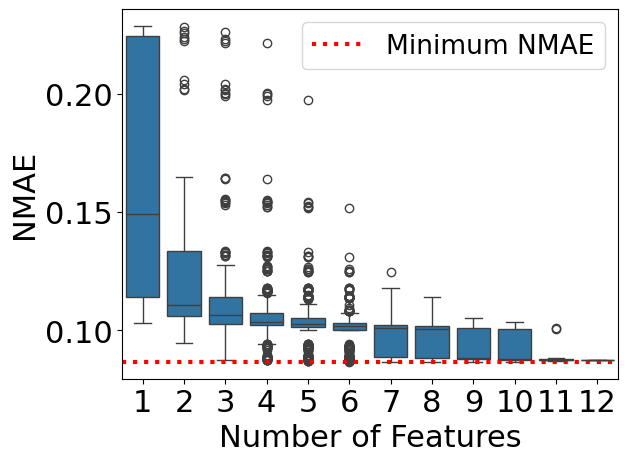

In [11]:
ax = sns.boxplot(data=result_df, x="features", y="NMAE")
ax.axhline(y=min_NMAE, linewidth=3, color='red', ls=':',label="Minimum NMAE")
plt.xlabel("Number of Features")
plt.legend(fontsize=19)
plt.savefig("NMAEvariance.pdf",bbox_inches='tight')